In [1]:
from configuration import BaseConfig
from datahandler import DataReader, DataWriter
import pandas as pd
import os
import matplotlib.pyplot as plt

config = BaseConfig(version=None).get_args(db_name="umls")

tui2stn = DataReader.load_json(config.tui2stn)
tui2str = DataReader.load_json(config.tui2str)

level1  = DataReader.load_json(config.level1)
level2  = DataReader.load_json(config.level2)
level3  = DataReader.load_json(config.level3)

umls_rel = DataReader.load_df(config.umls_rel)

umls_entity = DataReader.load_df(config.umls_entity)

print(f"size of UMLS‌ relation detection set:{umls_rel.shape[0]:_}")
print(f"size of UMLS‌ entity detection set:{umls_entity.shape[0]:_}")

display(umls_rel.head(3))
display(umls_entity.head(3))

size of UMLS‌ relation detection set:19_783_580
size of UMLS‌ entity detection set:2_093_042


,CUI1,CUI2,RELA,SAB-CUI1,STR-CUI1,SAB-CUI2,STR-CUI2
0,C0000039,C0043950,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,"3,5,8-Trioxa-4-phosphatetracosan-1-aminium, 4-..."
1,C0000039,C0216971,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,NCI,"(R)-(4-Oxido-10-oxo-7-palmitoyl-3,5,9-trioxa-4..."
2,C0000039,C0381030,mapped_to,MSH,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,MSH,DEPN-8


,CUI,STR,TUIs,STNs,SAB,level-1,level-2,level-3,level-4
0,C0000039,DIPALMITOYLPHOSPHATIDYLCHOLINE 0102,"['T109', 'T121']","['A1.4.1.2.1', 'A1.4.1.1.1']",MSH,A1,A1.4,A1.4.1,A1.4.1.2
1,C0000052,ALPHA GLUCAN BRANCHING ENZYME 01 04,"['T116', 'T126']","['A1.4.1.2.1.7', 'A1.4.1.1.3.3']",MSH,A1,A1.4,A1.4.1,A1.4.1.2
2,C0000084,CARBOXYGLUTAMIC ACID 01,"['T116', 'T123']","['A1.4.1.2.1.7', 'A1.4.1.1.3']",MSH,A1,A1.4,A1.4.1,A1.4.1.2


In [18]:
def cleaner(string):
    rserved_words = ["inverse", "of", "has", "as", "from", "to", "by", "is"]
    words = string.split("_")
    if len(words) == 1:
        return string
    
    new_words = []
    for word in words:
        if word not in rserved_words:
            new_words.append(word)
    return "_".join(new_words)

def filter_based_on_sab(sab, rel_threshold=1000):
    sab_rel_df = umls_rel[umls_rel['SAB-CUI1'].isin([sab]) & umls_rel['SAB-CUI2'].isin([sab])].reset_index()
    sab_rel_df['RELA'] = sab_rel_df['RELA'].apply(cleaner)
    
    sab_rel_df = sab_rel_df[sab_rel_df['RELA'].isin(list(sab_rel_df['RELA'].value_counts().loc[lambda X: X >= rel_threshold].keys()))].reset_index()
    
    print(f"# of samples in {sab} relation dataset is : {sab_rel_df.shape[0]:_}")
    sab_ents_list = sab_rel_df['CUI1'].tolist() + sab_rel_df['CUI2'].tolist()
    sab_ents_list = list(set(sab_ents_list))
    sab_ent_df = umls_entity[umls_entity['CUI'].isin(sab_ents_list)].reset_index()
    print(f"# of samples in {sab} entity detection dataset is: {sab_ent_df.shape[0]:_}")
    return sab_rel_df, sab_ent_df

relations_to_consider = ["NCI", "SNOMEDCT_US", "MEDCIN"]

umls_rel_nci_df, umls_ent_nci_df = filter_based_on_sab("NCI")
umls_rel_snomed_df, umls_ent_snomed_df = filter_based_on_sab("SNOMEDCT_US")
umls_rel_medicin_df, umls_ent_medicin_df = filter_based_on_sab("MEDCIN")

# of samples in NCI relation dataset is : 1_018_402
# of samples in NCI entity detection dataset is: 110_114
# of samples in SNOMEDCT_US relation dataset is : 2_921_702
# of samples in SNOMEDCT_US entity detection dataset is: 338_442
# of samples in MEDCIN relation dataset is : 946_042
# of samples in MEDCIN entity detection dataset is: 333_380


# Relation + Entity Type Analysis

## 1. NCI

<AxesSubplot: >

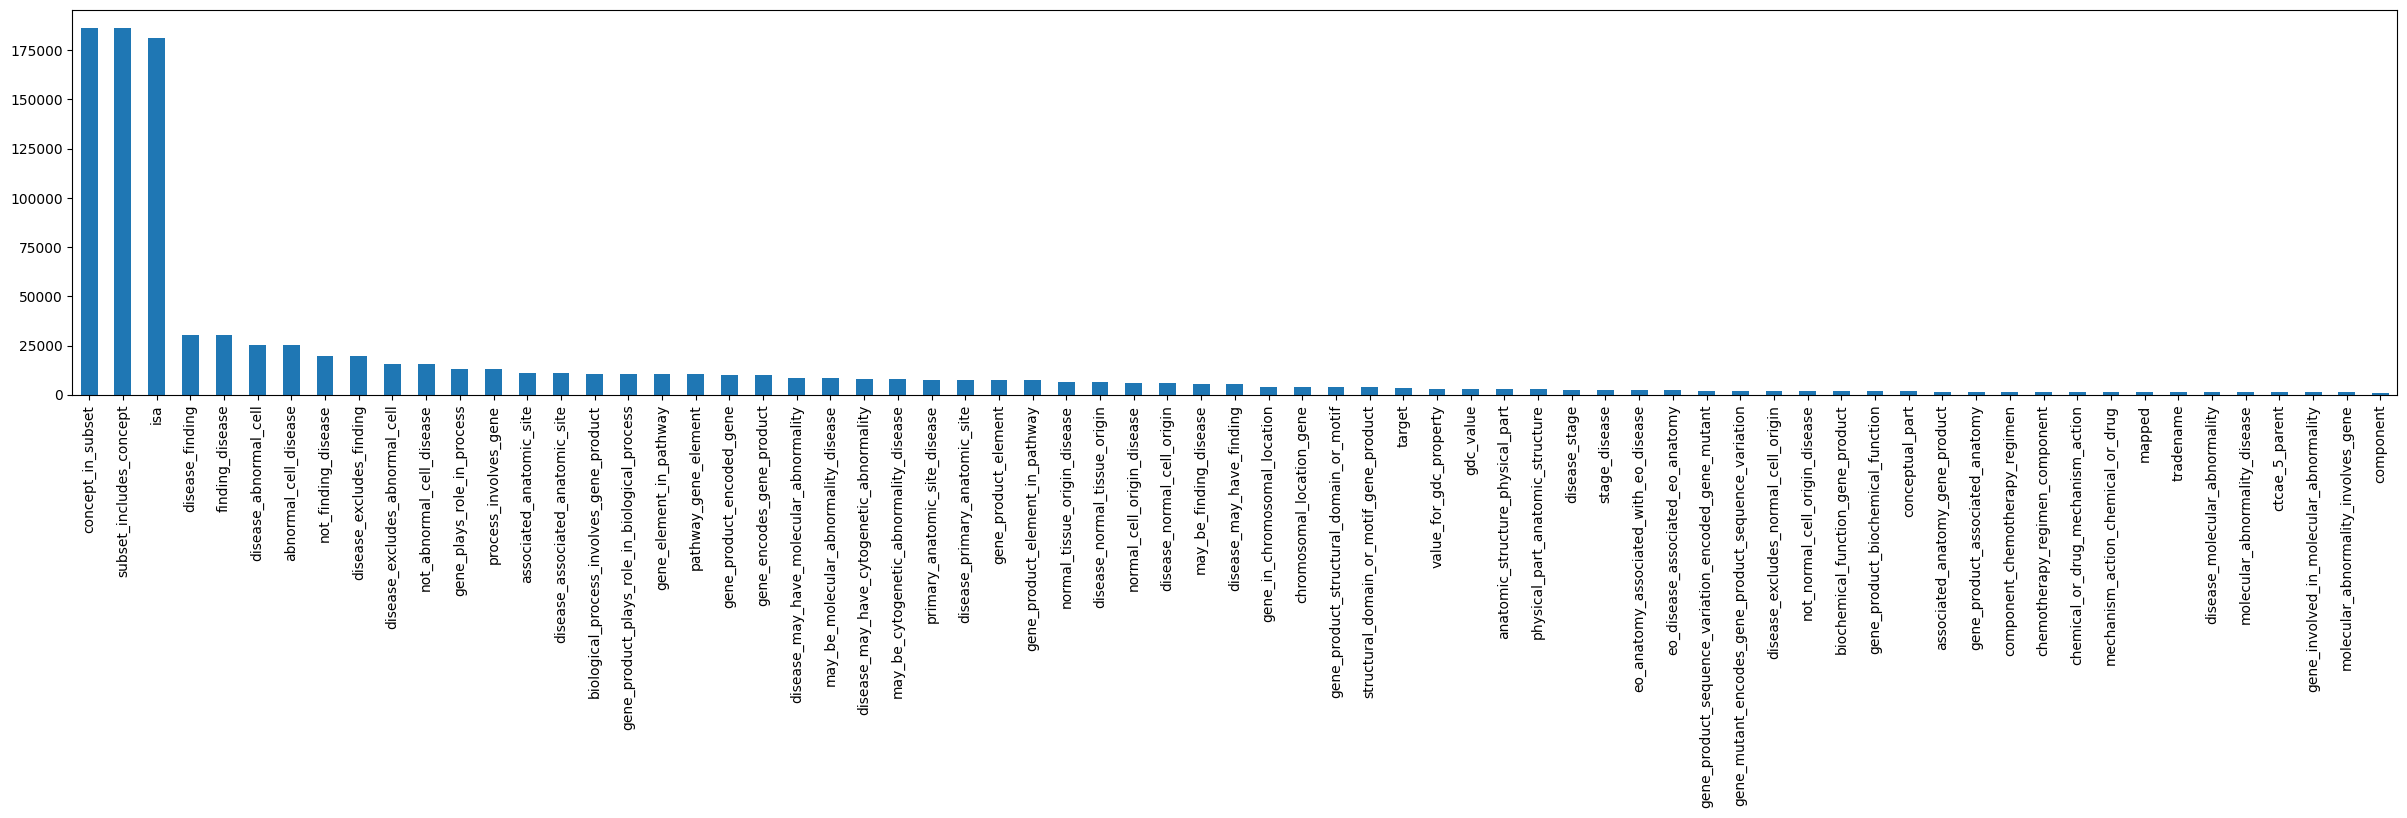

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 1, figsize=(30,5))
umls_rel_nci_df['RELA'].value_counts().plot(ax=axs, kind='bar')

In [29]:
print("Level 1 class FQs:\n", umls_ent_nci_df['level-1'].value_counts())

Level 1 class FQs:
 A2    53174
A1    31920
B2    16532
B1     8431
B        47
A        10
Name: level-1, dtype: int64


In [30]:
pd.DataFrame(umls_ent_nci_df[['level-3', 'level-4']].groupby("level-3").value_counts())

0
level-3 level-4        
A1.1.3  A1.1.3.1    301
        A1.1.3.3    231
        A1.1.3.2     21
A1.2.2  A1.2.2.1     53
        A1.2.2.2      5
        B2.2.1.2      1
A1.2.3  A1.2.3.5   6590
        A1.2.3.3   1672
        A1.2.3.4   1123
        A1.2.3.1    724
        A1.2.3.2    444
        A1.4.1.1     11
A1.3.1  A1.3.1.1      2
A1.4.1  A1.4.1.2  15753
        A1.4.1.1   3178
A2.1.4  A2.1.4.1     28
A2.1.5  A2.1.5.4   3411
        A2.1.5.3    219
        A2.1.5.2    152
        A2.1.5.1     78
B1.3.1  B1.3.1.3   3720
        B1.3.1.1   2666
        B1.3.1.2    527
B1.3.2  B1.3.2.1    131
B2.2.1  B2.2.1.2  15403
        B2.2.1.1    839

In [31]:
pd.DataFrame(umls_ent_nci_df[['level-1', 'level-2']].groupby("level-1").value_counts())

0
level-1 level-2       
A1      A1.4     19203
        A1.2     10820
        A1.3      1050
        A1.1       842
A2      A2.4     21245
        A2.2     16915
        A2.1     12318
        A2.9      1124
        A2.7       458
        A2.6       257
        A2.3       219
        A2.5        76
        A1.3        53
        A2.8         5
B1      B1.3      8152
        B1.4        41
        B1.1        21
        B1.2        21
B2      B2.2     16288
        B2.3        78
        B2.1         7

## 2. SNOMED_US

<AxesSubplot: >

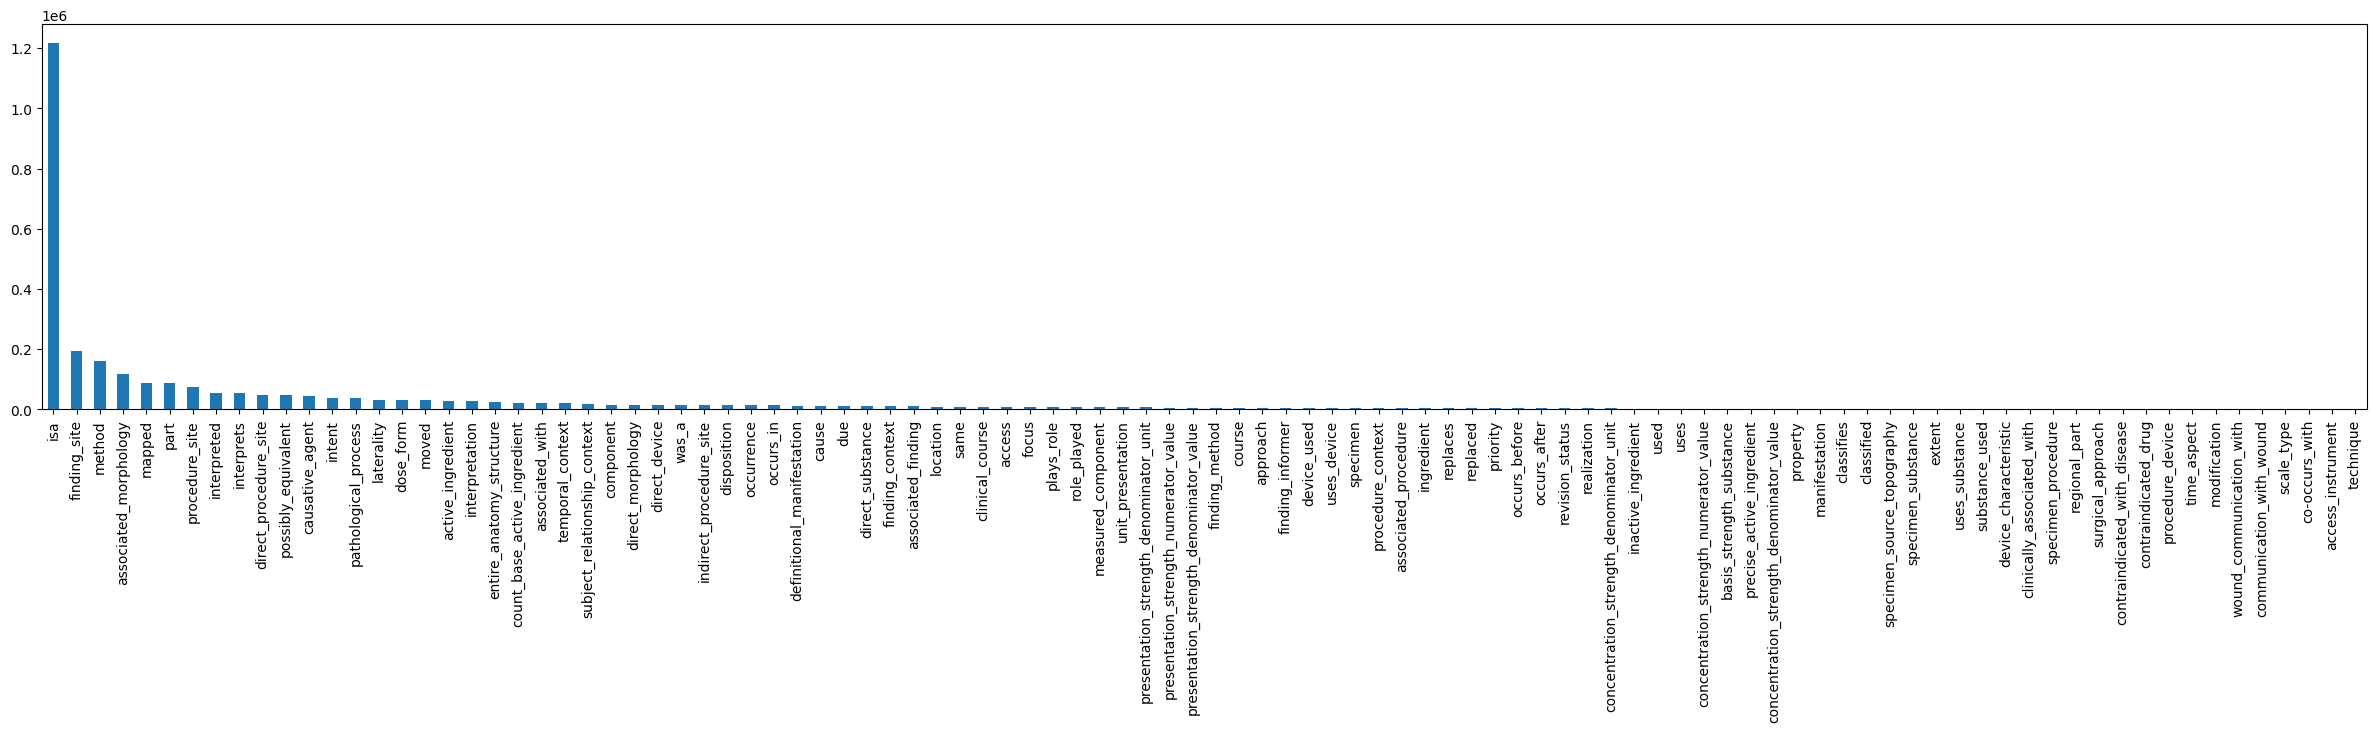

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(30,5))
umls_rel_snomed_df['RELA'].value_counts().plot(ax=axs, kind='bar')
# umls_rel_medicin_df['RELA'].value_counts().plot(ax=axs[2], kind='bar')

In [32]:
print("Level 1 class FQs:\n", umls_ent_snomed_df['level-1'].value_counts())

Level 1 class FQs:
 A1    121799
A2     77478
B2     76400
B1     62650
B        109
A          6
Name: level-1, dtype: int64


In [36]:
pd.DataFrame(umls_ent_snomed_df[['level-3', 'level-4']].groupby("level-3").value_counts())

0
level-3 level-4        
A1.1.3  A1.1.3.1   5036
        A1.1.3.2   1343
        A1.1.3.3   1037
A1.2.2  A1.2.2.1   5262
        A1.2.2.2   1676
        B2.2.1.2    203
A1.2.3  A1.2.3.1  22478
        A1.2.3.2   2190
        A1.2.3.3    708
        A1.2.3.4    481
        A1.2.3.5    320
A1.3.1  A1.3.1.1    111
A1.4.1  A1.4.1.2  19205
        A1.4.1.1  12474
A2.1.4  A2.1.4.1    253
A2.1.5  A2.1.5.2   4643
        A2.1.5.1   2861
        A2.1.5.4    786
        A2.1.5.3      6
B1.3.1  B1.3.1.3  36148
        B1.3.1.1   8899
        B1.3.1.2   8894
B1.3.2  B1.3.2.1     13
B2.2.1  B2.2.1.2  49414
        B2.2.1.1   1814

In [37]:
pd.DataFrame(umls_ent_snomed_df[['level-1', 'level-2']].groupby("level-1").value_counts())

0
level-1 level-2       
A1      A1.4     35738
        A1.2     35436
        A1.3     26103
        A1.1     24505
A2      A2.2     46994
        A2.1     16789
        A2.4      4980
        A2.9      4858
        A2.3      2354
        A2.5       661
        A2.7       402
        A1.3       220
        A2.6       188
        A2.8        15
B1      B1.3     62064
        B1.1       441
        B1.2       117
        B1.4         4
B2      B2.2     51592
        B2.3     24441
        B2.1       159

## 3. MEDICIN

<AxesSubplot: >

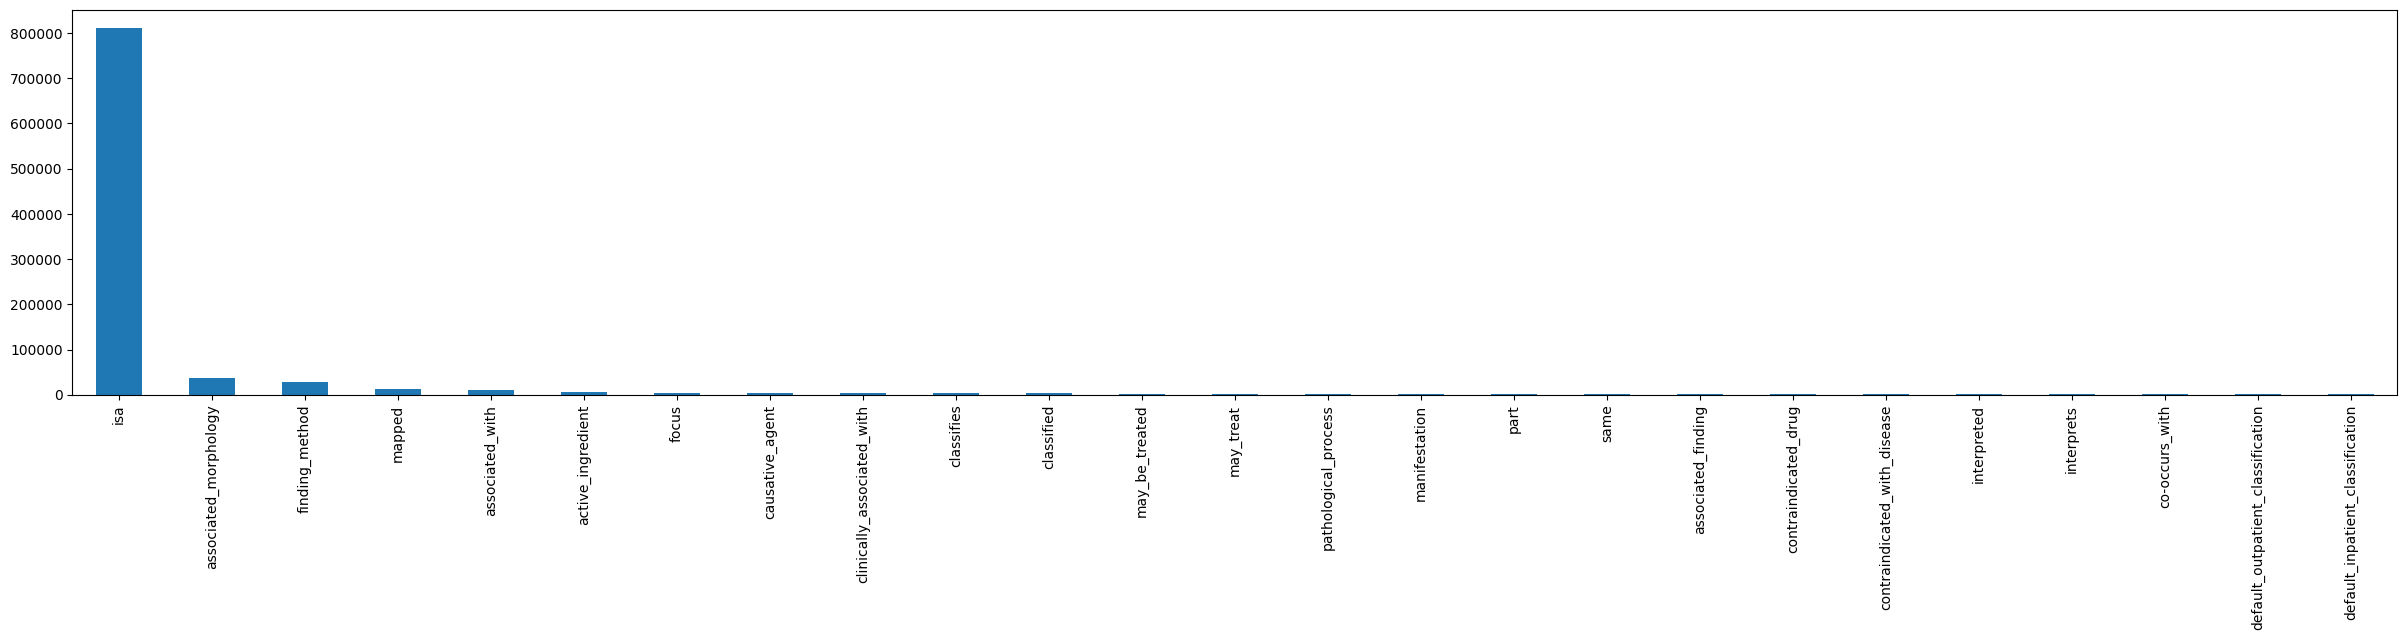

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(30,5))
umls_rel_medicin_df['RELA'].value_counts().plot(ax=axs, kind='bar')

In [33]:
print("Level 1 class FQs:\n", umls_ent_medicin_df['level-1'].value_counts())

Level 1 class FQs:
 A2    172924
B1     85349
B2     64095
A1     11012
Name: level-1, dtype: int64


In [34]:
pd.DataFrame(umls_ent_medicin_df[['level-3', 'level-4']].groupby("level-3").value_counts())

0
level-3 level-4        
A1.2.2  A1.2.2.1    980
        A1.2.2.2    963
        B2.2.1.2     40
A1.2.3  A1.2.3.1     19
        A1.2.3.3     14
        A1.2.3.4      1
A1.3.1  A1.3.1.1      3
A1.4.1  A1.4.1.2   3746
        A1.4.1.1   2030
A2.1.4  A2.1.4.1      2
A2.1.5  A2.1.5.2      2
B1.3.1  B1.3.1.3  46094
        B1.3.1.1  17128
        B1.3.1.2  15716
B1.3.2  B1.3.2.1      9
B2.2.1  B2.2.1.2  45451
        B2.2.1.1     41

In [35]:
pd.DataFrame(umls_ent_medicin_df[['level-1', 'level-2']].groupby("level-1").value_counts())

0
level-1 level-2        
A1      A1.4       5882
        A1.2       2631
        A1.3       2493
        A1.1          6
A2      A2.2     170104
        A2.4       2086
        A2.1        462
        A2.3        113
        A1.3         96
        A2.9         40
        A2.7         13
        A2.8          8
        A2.6          2
B1      B1.3      85271
        B1.1         51
        B1.2          9
B2      B2.2      45529
        B2.3      18558
        B2.1          8